# Hacker News EDA

## Initialization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from typing import Optional
import dask.dataframe as dd
from dask.diagnostics.progress import ProgressBar
import seaborn as sns
import dask
import numpy as np
from dask.distributed import Client

In [3]:
N_WORKERS = 8

client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=1,
    processes=True,
    silence_logs=True,
    memory_limit='30GB'
)

print(f"✅ Dask dashboard: {client.dashboard_link}")

2025-10-17 19:04:23,197 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-10-17 19:04:23,262 - distributed.scheduler - INFO - State start
2025-10-17 19:04:23,268 - distributed.diskutils - INFO - Found stale lock file and directory 'C:\\Users\\dmitr\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-1diapyqs', purging
2025-10-17 19:04:23,271 - distributed.diskutils - INFO - Found stale lock file and directory 'C:\\Users\\dmitr\\AppData\\Local\\Temp\\dask-scratch-space\\worker-52iofo8d', purging
2025-10-17 19:04:23,274 - distributed.diskutils - INFO - Found stale lock file and directory 'C:\\Users\\dmitr\\AppData\\Local\\Temp\\dask-scratch-space\\worker-7agb4337', purging
2025-10-17 19:04:23,277 - distributed.diskutils - INFO - Found stale lock file and directory 'C:\\Users\\dmitr\\AppData\\Local\\Temp\\dask-scratch-space\\worker-7opvlgk6', purging
2025-10-17 19:04:23,280 - d

✅ Dask dashboard: http://127.0.0.1:8787/status


## Data read

In [4]:
def html_to_text(html: Optional[str]) -> Optional[str]:
    if pd.isna(html):
        return ''
    soup = BeautifulSoup(html, 'lxml')
    return soup.get_text(separator=' ', strip=True)

In [5]:
# Read items using dask
# Sample first to infer consistent schema across all blocks
items = dd.read_json('../data/items.jsonl', lines=True, blocksize=None)
items = items.repartition(npartitions=N_WORKERS)

items['time'] = dd.to_datetime(items['time'], unit='s')

# Apply text extraction functions
items['text_extracted'] = items['text'].apply(html_to_text, meta=('text', 'object'))
items['title_extracted'] = items['title'].apply(html_to_text, meta=('title', 'object'))

with ProgressBar():
    items = items.persist()

# Display the first few rows
items.head()

,by,id,parent,text,time,type,descendants,score,title,url,dead,kids,deleted,poll,parts,text_extracted,title_extracted
0,a456463,45598821,45597064.0,I came to chime in. I have hardware that apple...,2025-10-15 22:00:09,comment,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,<NA>,I came to chime in. I have hardware that apple...,
1,_aavaa_,45598820,45598735.0,"Or: <a href=""https:&#x2F;&#x2F;decoding-the-gu...",2025-10-15 22:00:08,comment,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,<NA>,Or: https://decoding-the-gurus.captivate.fm/ep...,
2,gdevillers,45598819,NaN,<NA>,2025-10-15 21:59:52,story,0.0,1.0,The secret sauce of Geekbench CPU benchmark [pdf],https://www.geekbench.com/doc/geekbench6-bench...,NaN,<NA>,NaN,NaN,<NA>,,The secret sauce of Geekbench CPU benchmark [pdf]
3,joshuabaker2,45598818,45596877.0,You can convert a PyTorch model to an ONNX mod...,2025-10-15 21:59:49,comment,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,<NA>,You can convert a PyTorch model to an ONNX mod...,
4,halayli,45598817,45596504.0,You&#x27;re comparing apples to oranges. In pu...,2025-10-15 21:59:41,comment,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,<NA>,You're comparing apples to oranges. In pure fu...,


In [6]:
# Read users using dask
users = dd.read_json('../data/users.jsonl', lines=True, blocksize=None)
users = users.repartition(npartitions=N_WORKERS)

users['created'] = dd.to_datetime(users['created'], unit='s')
users['about_extracted'] = users['about'].apply(html_to_text, meta=('about', 'object'))

with ProgressBar():
    users = users.persist()

users.head()

,created,id,karma,submitted,about,about_extracted
0,2025-10-15 21:35:24,theycallmerick,1,"[45598814, 45598795, 45598666, 45598611]",<NA>,
1,2014-08-28 03:44:33,shitloadofbooks,831,"[45598797, 45153434, 44936200, 44372175, 44253...",<NA>,
2,2019-02-22 15:50:21,andersmurphy,412,"[45598767, 45598715, 45598704, 45598345, 45598...",<NA>,
3,2009-03-27 16:01:18,grogers,905,"[45598774, 45574331, 45573395, 45550449, 45545...",<NA>,
4,2017-02-15 17:01:00,verall,2162,"[45598772, 45550826, 45070589, 44974187, 44896...",CompEng working in camera systems and SoC :)<p...,CompEng working in camera systems and SoC :) v...


In [7]:
posts = items[items['type'].isin(['story', 'poll', 'job'])]
posts.head()

,by,id,parent,text,time,type,descendants,score,title,url,dead,kids,deleted,poll,parts,text_extracted,title_extracted
2,gdevillers,45598819,NaN,<NA>,2025-10-15 21:59:52,story,0.0,1.0,The secret sauce of Geekbench CPU benchmark [pdf],https://www.geekbench.com/doc/geekbench6-bench...,NaN,<NA>,NaN,NaN,<NA>,,The secret sauce of Geekbench CPU benchmark [pdf]
41,wjb3,45598780,NaN,<NA>,2025-10-15 21:54:46,story,1.0,1.0,Is Fecal Transplantation Effective for Depress...,https://www.medscape.com/viewarticle/fecal-tra...,NaN,[45598784],NaN,NaN,<NA>,,Is Fecal Transplantation Effective for Depress...
45,vincent-uden,45598776,NaN,<NA>,2025-10-15 21:54:14,story,0.0,1.0,I Hate Acrobat,https://www.vincentuden.xyz/blog/pdf-reader,NaN,<NA>,NaN,NaN,<NA>,,I Hate Acrobat
63,0xlogk,45598758,NaN,<NA>,2025-10-15 21:52:00,story,0.0,8.0,Show HN: I built an AI companion with persiste...,https://dmwithme.com,NaN,<NA>,NaN,NaN,<NA>,,Show HN: I built an AI companion with persiste...
103,debesyla,45598718,NaN,<NA>,2025-10-15 21:46:56,story,0.0,1.0,Junior Engineers in the Age of AI,https://vidmantas.kabosis.lt/junior-ai-age,NaN,<NA>,NaN,NaN,<NA>,,Junior Engineers in the Age of AI


## EDA

### 1. In general, how many posts are related to AI over time on HackerNews? 


In [8]:
# Define AI-related keywords and patterns

ai_keywords = [
    # Core AI terms
    'artificial intelligence', 'machine learning', 'deep learning', 
    'neural network', 'neural net',
    
    # Abbreviations
    r'\bai\b', r'\bml\b', r'\bllm\b', r'\bnlp\b', r'\bcv\b',
    
    # Models & Architectures
    'gpt', 'bert', 'transformer', 'diffusion', 'gan', 'cnn', 'rnn', 
    'lstm', 'attention mechanism',
    
    # Specific Products/Services
    'chatgpt', 'claude', 'gemini', 'copilot', 'midjourney', 'stable diffusion',
    'openai', 'anthropic', 'hugging face', 'huggingface',
    
    # Frameworks & Tools
    'pytorch', 'tensorflow', 'keras', 'scikit-learn', 'langchain',
    
    # Techniques & Concepts
    'reinforcement learning', 'supervised learning', 'unsupervised learning',
    'computer vision', 'natural language processing', 'embedding', 
    'fine-tuning', 'prompt engineering', 'rag', 'retrieval augmented',
    'generative ai', 'genai', 'large language model'
]

pattern = '|'.join(ai_keywords)

In [9]:
ai_posts = posts[
    posts['title_extracted'].str.contains(pattern, case=False, na=False, regex=True) |
    posts['text_extracted'].str.contains(pattern, case=False, na=False, regex=True)
]

In [10]:
with ProgressBar():
    ai_posts = ai_posts.compute()
ai_posts.head()

,by,id,parent,text,time,type,descendants,score,title,url,dead,kids,deleted,poll,parts,text_extracted,title_extracted
63,0xlogk,45598758,NaN,<NA>,2025-10-15 21:52:00,story,0.0,8.0,Show HN: I built an AI companion with persiste...,https://dmwithme.com,NaN,<NA>,NaN,NaN,<NA>,,Show HN: I built an AI companion with persiste...
103,debesyla,45598718,NaN,<NA>,2025-10-15 21:46:56,story,0.0,1.0,Junior Engineers in the Age of AI,https://vidmantas.kabosis.lt/junior-ai-age,NaN,<NA>,NaN,NaN,<NA>,,Junior Engineers in the Age of AI
182,mgh2,45598639,NaN,<NA>,2025-10-15 21:38:36,story,0.0,1.0,A Visualization of OpenAI and Nvidia's Tangled...,https://www.youtube.com/watch?v=FSbq0T7j77g,NaN,<NA>,NaN,NaN,<NA>,,A Visualization of OpenAI and Nvidia's Tangled...
209,justiceforai,45598612,NaN,"OpenAI board member, CEO of Quora (Poe.com), A...",2025-10-15 21:35:25,story,0.0,1.0,OpenAI board member is selling ChatGPT / Claud...,<NA>,NaN,<NA>,NaN,NaN,<NA>,"OpenAI board member, CEO of Quora (Poe.com), A...",OpenAI board member is selling ChatGPT / Claud...
249,fzliu,45598572,NaN,<NA>,2025-10-15 21:29:55,story,0.0,1.0,Can Long-Context Language Models Subsume Retri...,https://arxiv.org/abs/2406.13121,NaN,<NA>,NaN,NaN,<NA>,,Can Long-Context Language Models Subsume Retri...


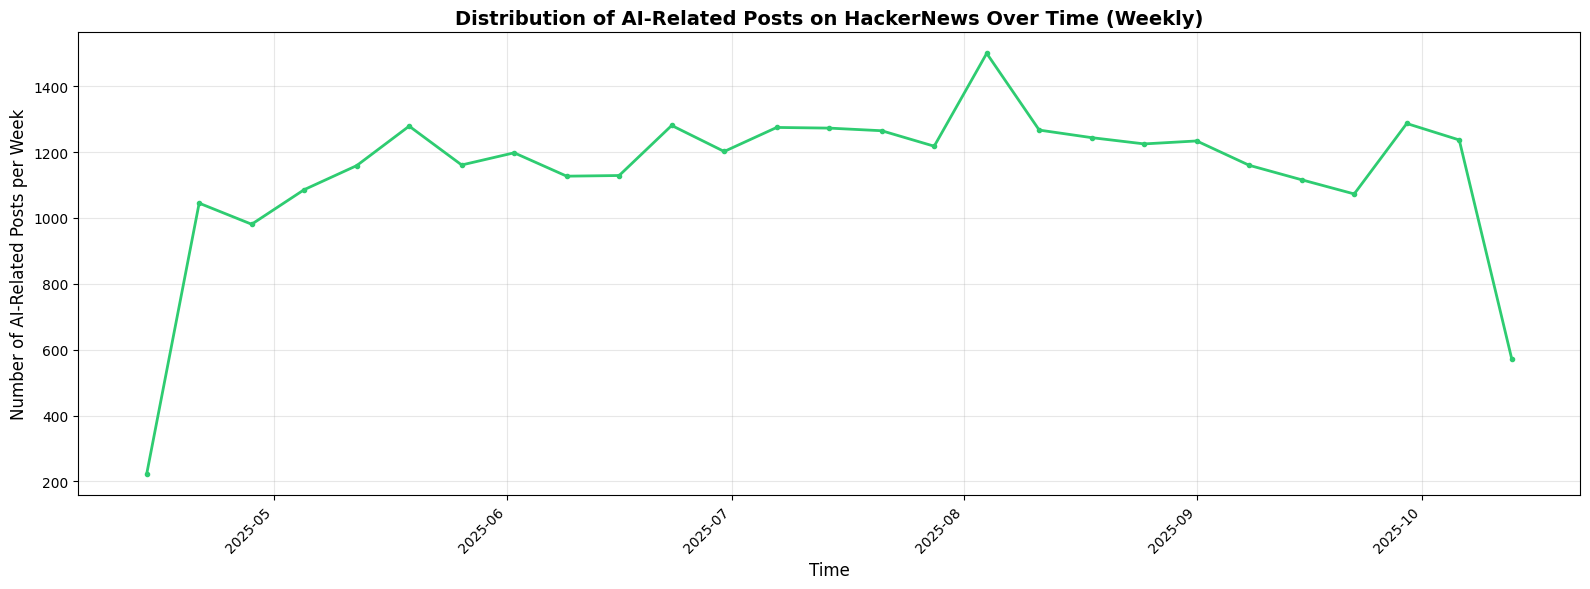

Total AI-related posts: 30,816
Time range: 2025-04-18 22:10:50 to 2025-10-15 21:52:00

Weekly statistics:
Mean posts per week: 1141.33
Median posts per week: 1202.00
Max posts in a week: 1500

Top 5 weeks with most AI posts:
      week  count
2025-08-04   1500
2025-09-29   1287
2025-06-23   1281
2025-05-19   1279
2025-07-07   1275


In [11]:
# Distribution of AI posts over time
ai_posts['week'] = ai_posts['time'].dt.to_period('W')
ai_posts_by_week = ai_posts.groupby('week').size().reset_index(name='count')
ai_posts_by_week['week'] = ai_posts_by_week['week'].dt.to_timestamp()

# Create line plot
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(ai_posts_by_week['week'], ai_posts_by_week['count'], 
        linewidth=2, color='#2ecc71', marker='o', markersize=3)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Number of AI-Related Posts per Week', fontsize=12)
ax.set_title('Distribution of AI-Related Posts on HackerNews Over Time (Weekly)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"Total AI-related posts: {len(ai_posts):,}")
print(f"Time range: {ai_posts['time'].min()} to {ai_posts['time'].max()}")
print(f"\nWeekly statistics:")
print(f"Mean posts per week: {ai_posts_by_week['count'].mean():.2f}")
print(f"Median posts per week: {ai_posts_by_week['count'].median():.2f}")
print(f"Max posts in a week: {ai_posts_by_week['count'].max()}")
print(f"\nTop 5 weeks with most AI posts:")
print(ai_posts_by_week.nlargest(5, 'count')[['week', 'count']].to_string(index=False))

### 2.What is the right time and day to post?


Computing time analysis data...


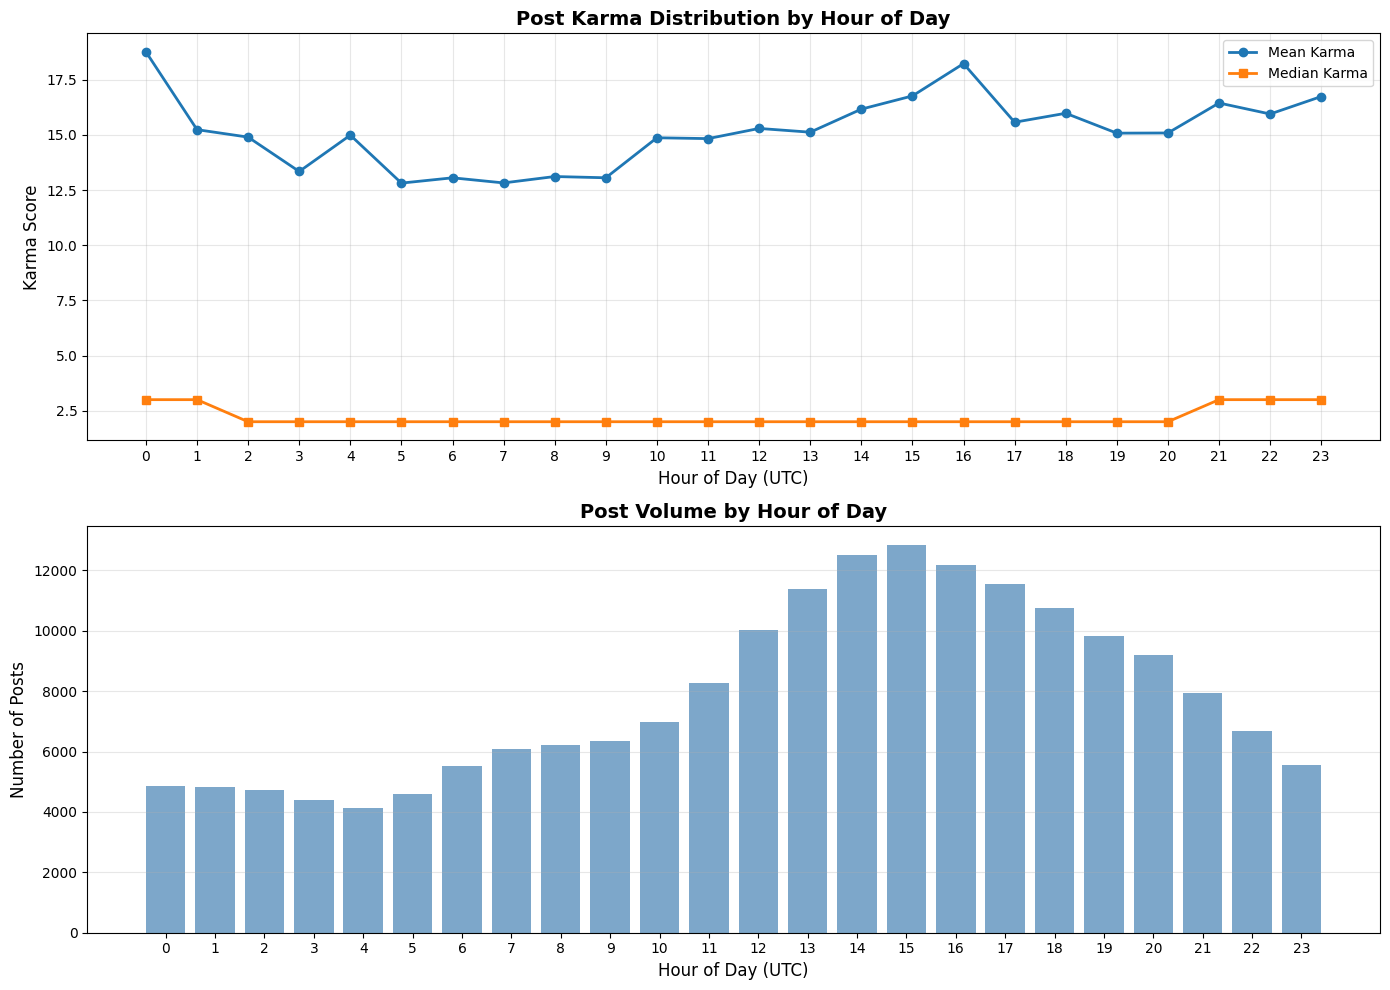

Karma Statistics by Hour of Day:
       mean  median  count
hour                      
0     18.76     3.0   4874
1     15.24     3.0   4821
2     14.90     2.0   4739
3     13.34     2.0   4399
4     14.99     2.0   4142
5     12.81     2.0   4603
6     13.05     2.0   5533
7     12.82     2.0   6080
8     13.11     2.0   6203
9     13.05     2.0   6340
10    14.87     2.0   6968
11    14.83     2.0   8257
12    15.29     2.0  10007
13    15.12     2.0  11374
14    16.16     2.0  12491
15    16.76     2.0  12830
16    18.23     2.0  12159
17    15.57     2.0  11530
18    15.98     2.0  10744
19    15.08     2.0   9819
20    15.08     2.0   9206
21    16.44     3.0   7952
22    15.94     3.0   6682
23    16.74     3.0   5564

Best hours for karma (by mean): [0, 16, 15, 23, 21]
Worst hours for karma (by mean): [5, 7, 6, 9, 8]


In [12]:
# What is the right time and day to post?

# Extract hour from timestamp (works on Dask Series)
items_with_hour = items.copy()
items_with_hour['hour'] = items_with_hour['time'].dt.hour

# Select only the columns we need and compute
print("Computing time analysis data...")
with ProgressBar():
    time_analysis = items_with_hour[['hour', 'score']].compute()

# Calculate average karma by hour
karma_by_hour = time_analysis.groupby('hour')['score'].agg(['mean', 'median', 'count'])

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average and Median Karma by Hour
axes[0].plot(karma_by_hour.index, karma_by_hour['mean'], marker='o', label='Mean Karma', linewidth=2)
axes[0].plot(karma_by_hour.index, karma_by_hour['median'], marker='s', label='Median Karma', linewidth=2)
axes[0].set_xlabel('Hour of Day (UTC)', fontsize=12)
axes[0].set_ylabel('Karma Score', fontsize=12)
axes[0].set_title('Post Karma Distribution by Hour of Day', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(24))

# Plot 2: Number of Posts by Hour
axes[1].bar(karma_by_hour.index, karma_by_hour['count'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Hour of Day (UTC)', fontsize=12)
axes[1].set_ylabel('Number of Posts', fontsize=12)
axes[1].set_title('Post Volume by Hour of Day', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

# Display summary statistics
print("Karma Statistics by Hour of Day:")
print(karma_by_hour.round(2))
print(f"\nBest hours for karma (by mean): {karma_by_hour['mean'].nlargest(5).index.tolist()}")
print(f"Worst hours for karma (by mean): {karma_by_hour['mean'].nsmallest(5).index.tolist()}")

### 3. Is there a best way to write a title for a post?

Let's look at the top 1% of posts by score. What are the most common words in these?

In [13]:
# Let's select top 1% of posts by score
top_1_percent_threshold = posts['score'].quantile(0.99).compute()
top_posts = posts[posts['score'] >= top_1_percent_threshold]

with ProgressBar():
    top_posts = top_posts.persist()

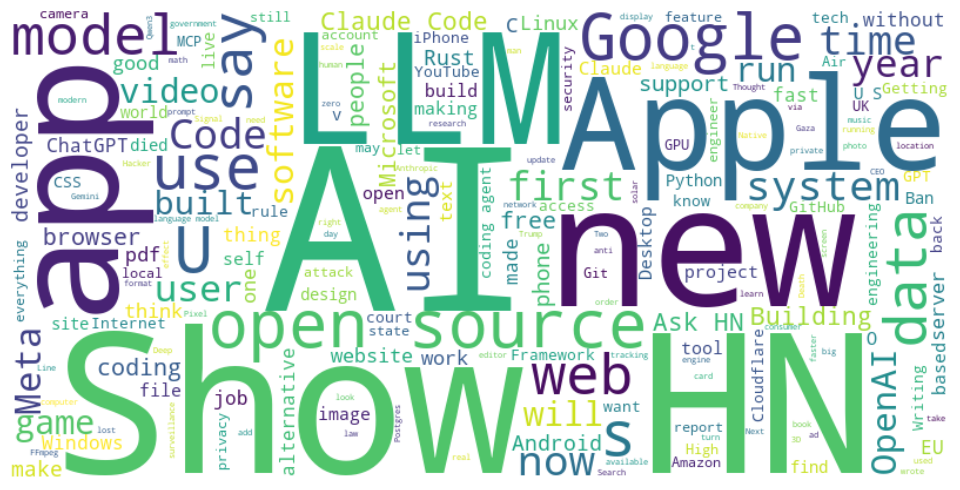

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all titles into a single string
text = ' '.join(top_posts['title'].astype(str))

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### 4. Can you create a set of rules on writing good title to reuse later in ChatGPT?


### 5. Does carma of people that comment posts correlate with the upvote count?


### 6. What performs better — Twitter links or GitHub links?


### 7. What is the impact of successful YC launches on GitHub stars count? 
Note: you should find out how many stars were there at the moment of YC launches

### 8. Write a short summary of your findings + ways to improve the things you just implemented


### 9. Can we detect patterns of reposts (same GitHub/Twitter/Blog link shared multiple times) and evaluate whether reposts perform better or worse than first-time submissions?

### 10. How does the comment activity (number of comments and length of discussions) correlate with the final upvote count of HackerNews posts?